In [164]:
import pandas as pd
import numpy as np
import seaborn as sns
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from IPython.display import display
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
shap.initjs()



In [165]:
#EASY CLEANING PAIRS
COL_UNIT_PAIRS = {'process_size': 'nm',
 'transistors': 'million',
 'die_size': 'mm²',
 'base_clock': 'MHz',
 'memory_bus': 'bit',
 'tdp' : 'W',
 'memory_clock': 'MHz',
 'pixel_rate': 'GPixel/s',
 'texture_rate': 'GTexel/s',}

### PULL DATA FROM CSV

In [166]:
#Pull original gpu spec data from CSV ----- RESET CSV
gpu_specs = pd.read_csv("data/gpu_specs_original.csv", index_col=0).to_dict(orient="index")
gpu_specs_df = pd.DataFrame.from_dict(gpu_specs, orient='index')


In [167]:
#Save as CSV ---- MALLEABLE
gpu_specs_df.to_csv("data/gpu_specs_clean.csv", index=True)

### DATA CLEANING

In [168]:
#Select Columns to keep
gpu_specs_df = gpu_specs_df[['architecture', 'process_size', 'transistors', 'density', 'die_size', 
                            'base_clock', 'memory_size', 'memory_type', 'memory_bus',
                            'bandwidth', 'shading_units', 'tmus', 'rops', 'l1_cache',
                            'l2_cache', 'directx', 'gpu_clock', 'tdp', 'memory_clock',
                            'fp32_(float)', 'fp64_(double)', 'pixel_rate',
                            'texture_rate']]

#Set name to index
gpu_specs_df.index.name = 'name'

#Remove Row due to outlier data
gpu_specs_df = gpu_specs_df.drop(index="AMD Radeon RX VEGA 10")

##### CLEANING FUNCTIONS

In [169]:
def clean_numeric_column(df, col, unit):
    # Replace "Unknown", "N/A", "-", None, etc. with NaN
    df[col] = df[col].replace(["Unknown", "N/A", "-", "", 'unknown'], pd.NA)

    # Remove commas and unit suffix (only affects non-null strings)
    df[col] = (
        df[col]
        .astype(str)
        .str.replace(",", "", regex=False)
        .str.replace(f" {unit}", "", regex=False)
    )

    # Convert to numeric safely (anything invalid -> NaN)
    df[col] = pd.to_numeric(df[col], errors="coerce")

    # Rename column to include the unit
    df.rename(columns={col: f"{col}_{unit}"}, inplace=True)
    
    return df

In [170]:
def normalize_flops(df, column, new_name):
    # 1. Clean commas
    df[column] = df[column].astype(str).str.replace(",", "")
    
    # 2. Extract numeric value
    df[f"{column}_value"] = df[column].str.extract(r"([\d\.]+)").astype(float)
    
    # 3. Extract unit (GFLOPS, TFLOPS)
    df[f"{column}_unit"] = df[column].str.extract(r"([A-Za-z]+)")
    
    # 4. Convert GFLOPS → TFLOPS
    df.loc[df[f"{column}_unit"].str.upper().str.startswith("G"), f"{column}_value"] /= 1000
    
    # 5. Round to 2 decimals
    df[f"{column}_value"] = df[f"{column}_value"].round(2)
    
    # 6. Insert normalized column
    col_idx = df.columns.get_loc(column)
    df.insert(col_idx, new_name, df[f"{column}_value"])
    
    # 7. Drop helper columns
    df.drop(columns=[f"{column}_value", f"{column}_unit", column], inplace=True)
    
    return df

In [171]:
def clean_directx(val):
    if "Ultimate" in str(val):
        return "12.1"
    return val

##### UNIT CONVERSIONS AND STRING --> NUMERIC

In [172]:
#Easy numeric cleaning
gpu_specs_df['base_clock'] = gpu_specs_df['base_clock'].fillna(gpu_specs_df['gpu_clock'])
gpu_specs_df = gpu_specs_df.drop(columns=['gpu_clock'])
for key, value in COL_UNIT_PAIRS.items():
    gpu_specs_df = clean_numeric_column(gpu_specs_df, key, value)
gpu_specs_df = normalize_flops(gpu_specs_df, "fp32_(float)", "fp32_TFLOPS")
gpu_specs_df = normalize_flops(gpu_specs_df, "fp64_(double)", "fp64_TFLOPS")

In [173]:
#More complicated numeric cleaning

#Density
unit = 'M / mm²'
col = 'density'
gpu_specs_df['density'] = (
    gpu_specs_df['density']
    .str.replace(",", "", regex=False)
    .str.replace(f"{unit}", "", regex=False)
    .astype(float)
)
# Add unit to the column name
gpu_specs_df.rename(columns={col: f"{col}_{unit.replace(' ', '_').replace('/', '_per_').replace('²','^2')}"}, inplace=True)

#Memory Size
gpu_specs_df["memory_value"] = gpu_specs_df["memory_size"].str.extract(r"([\d\.]+)").astype(float)
gpu_specs_df["memory_unit"] = gpu_specs_df["memory_size"].str.extract(r"([A-Za-z]+)")
col_idx = gpu_specs_df.columns.get_loc("memory_size")
gpu_specs_df.loc[gpu_specs_df["memory_unit"] == "MB", "memory_value"] /= 1024
gpu_specs_df.insert(col_idx, "memory_size_GB", gpu_specs_df["memory_value"])
gpu_specs_df = gpu_specs_df.drop(columns=["memory_value", "memory_unit", "memory_size"])

#Bandwidth
#Extract the unit (GB/s or TB/s)
gpu_specs_df["bandwidth_value"] = gpu_specs_df["bandwidth"].str.extract(r"([\d\.]+)").astype(float)
gpu_specs_df["bandwidth_unit"] = gpu_specs_df["bandwidth"].str.extract(r"([A-Za-z/]+)")
#Find the column index of 'bandwidth'
col_idx = gpu_specs_df.columns.get_loc("bandwidth")
#Convert TB/s → GB/s
gpu_specs_df.loc[gpu_specs_df["bandwidth_unit"] == "TB/s", "bandwidth_value"] *= 1024
#Insert normalized column (all values in GB/s)
gpu_specs_df.insert(col_idx, "bandwidth_GBs", gpu_specs_df["bandwidth_value"])
#Drop intermediate columns
gpu_specs_df = gpu_specs_df.drop(columns=["bandwidth_value", "bandwidth_unit", "bandwidth"])

#l1 Cache
col = 'l1_cache'
gpu_specs_df[col] = gpu_specs_df[col].str.extract(r"([\d\.]+)").astype(float)
# Rename with unit + qualifier
gpu_specs_df.rename(columns={col: f"{col}_KB_per_CU"}, inplace=True)

#l2 Cache
gpu_specs_df["cache_value"] = gpu_specs_df["l2_cache"].str.extract(r"([\d\.]+)").astype(float)
gpu_specs_df["cache_unit"] = gpu_specs_df["l2_cache"].str.extract(r"([A-Za-z]+)")
col_idx = gpu_specs_df.columns.get_loc("l2_cache")
gpu_specs_df.loc[gpu_specs_df["cache_unit"] == "KB", "cache_value"] /= 1024
gpu_specs_df.insert(col_idx, "l2_cache_MB", gpu_specs_df["cache_value"])
gpu_specs_df = gpu_specs_df.drop(columns=["cache_value", "cache_unit", "l2_cache"])

#DirectX
gpu_specs_df['directx'] = gpu_specs_df['directx'].apply(clean_directx).astype(float)

#Fill Lingering NaN
gpu_specs_df["l1_cache_KB_per_CU"] = gpu_specs_df["l1_cache_KB_per_CU"].fillna(0)
gpu_specs_df["fp64_TFLOPS"] = gpu_specs_df["fp64_TFLOPS"].fillna(0)
gpu_specs_df["tdp_W"] = gpu_specs_df["tdp_W"].fillna(0)

In [174]:
def group_top_categories(df, column, top_n=5, new_col_name=None):
    """
    Group categorical column into top_n categories + 'Other'.
    
    Parameters
    ----------
    df : DataFrame
        Input DataFrame.
    column : str
        Column name to group.
    top_n : int
        Number of most frequent categories to keep.
    new_col_name : str or None
        Name for new column. If None, overwrites the original column.
    
    Returns
    -------
    DataFrame : updated DataFrame with grouped column.
    """
    if new_col_name is None:
        new_col_name = column
    
    # Get top N categories
    top_categories = df[column].value_counts().nlargest(top_n).index
    
    # Map values
    df[new_col_name] = df[column].apply(lambda x: x if x in top_categories else "Other")
    
    return df

In [175]:
# Group architecture into top 5 + Other
gpu_specs_df = group_top_categories(gpu_specs_df, "architecture", top_n=5)

# Group memory_type into top 3 + Other
gpu_specs_df = group_top_categories(gpu_specs_df, "memory_type", top_n=5)

In [176]:
# SAVE CLEANED DATA
gpu_specs_df.to_csv("data/gpu_specs_clean.csv", index=True)

##### COMBINE WITH FPS DATASET

In [177]:
fps_df = pd.read_csv("data/gpu_fps_only.csv", index_col=0)
fps_df['Avg_FPS'] = fps_df['Avg_FPS'].str.replace(",", "", regex=False).astype(float)
fps_df = fps_df.drop(columns = "Min_FPS")

In [178]:
gpu_joined = gpu_specs_df.join(fps_df, how = 'inner')
gpu_joined[gpu_joined.select_dtypes(include=['number']).columns] = gpu_joined.select_dtypes(include=['number']).apply(lambda x: x.astype(float))
gpu_joined.to_csv("data/gpu_data_final.csv", index=True)

In [179]:
print(gpu_joined.dtypes)

architecture              object
process_size_nm          float64
transistors_million      float64
density_M__per__mm^2     float64
die_size_mm²             float64
base_clock_MHz           float64
memory_size_GB           float64
memory_type               object
memory_bus_bit           float64
bandwidth_GBs            float64
shading_units            float64
tmus                     float64
rops                     float64
l1_cache_KB_per_CU       float64
l2_cache_MB              float64
directx                  float64
tdp_W                    float64
memory_clock_MHz         float64
fp32_TFLOPS              float64
fp64_TFLOPS              float64
pixel_rate_GPixel/s      float64
texture_rate_GTexel/s    float64
Game_Name                 object
Avg_FPS                  float64
Setting                   object
Resolution                object
dtype: object


In [180]:
feature_labels = {
    "architecture": "Architecture",
    "process_size_nm": "Process Size (nm)",
    "transistors_million": "Transistors (M)",
    "density_M__per__mm^2": "Transistor Density (M/mm²)",
    "die_size_mm²": "Die Size (mm²)",
    "base_clock_MHz": "Base Clock (MHz)",
    "memory_size_GB": "Memory Size (GB)",
    "memory_type": "Memory Type",
    "memory_bus_bit": "Memory Bus (bit)",
    "bandwidth_GBs": "Memory Bandwidth (GB/s)",
    "shading_units": "Shading Units",
    "tmus": "Texture Mapping Units (TMUs)",
    "rops": "Render Output Units (ROPs)",
    "l1_cache_KB_per_CU": "L1 Cache (KB per CU)",
    "l2_cache_MB": "L2 Cache (MB)",
    "directx": "DirectX Version",
    "tdp_W": "Power (TDP, W)",
    "memory_clock_MHz": "Memory Clock (MHz)",
    "fp32_TFLOPS": "FP32 Throughput (TFLOPS)",
    "fp64_TFLOPS": "FP64 Throughput (TFLOPS)",
    "pixel_rate_GPixel/s": "Pixel Rate (GPixel/s)",
    "texture_rate_GTexel/s": "Texture Rate (GTexel/s)",
    "Game_Name": "Game Title",
    "Avg_FPS": "Average FPS",
    "Setting": "Graphics Setting",
    "Resolution": "Resolution"
}

### DATA ANALYSIS

In [181]:
X = gpu_joined.drop(columns=["Avg_FPS"])  # features
y = gpu_joined["Avg_FPS"]                 # target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [182]:
numeric_features = gpu_joined.select_dtypes(include=["float64"]).drop(columns=["Avg_FPS"]).columns.tolist()
hardware_categorical_features = ["architecture", "memory_type"]

# Software/demand features
software_features = ["Resolution", "Setting"]

# Combine all features
all_features = numeric_features + hardware_categorical_features + software_features
all_hw_features = numeric_features + hardware_categorical_features

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

### Raw Feature Analysis

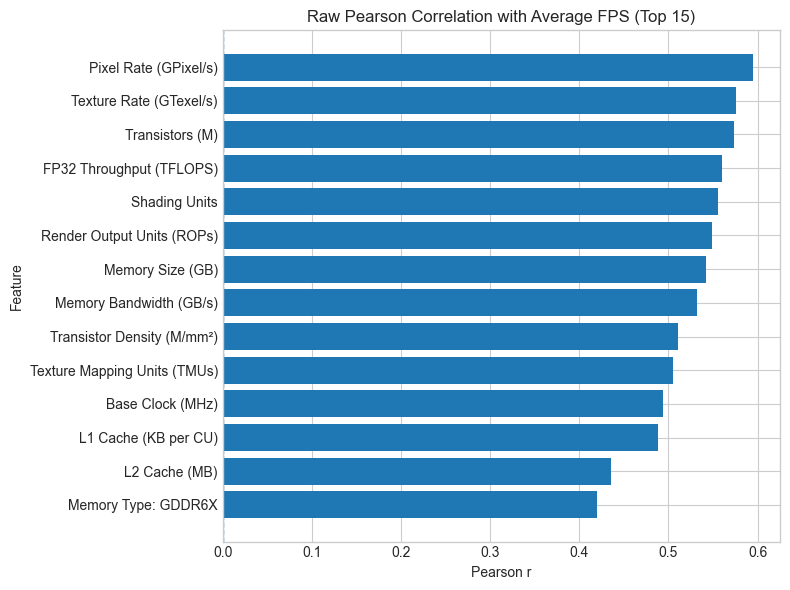

In [183]:
TARGET = "Avg_FPS"

# -----------------------------
# 1) Build an analysis matrix X
# -----------------------------
cat_cols = hardware_categorical_features + software_features
X_cat = pd.get_dummies(gpu_joined[cat_cols], drop_first=False, dtype=float)

num_cols = [c for c in numeric_features if c in gpu_joined.columns and c != TARGET]
X_num = gpu_joined[num_cols].apply(pd.to_numeric, errors="coerce")

X = pd.concat([X_num, X_cat], axis=1)

y = pd.to_numeric(gpu_joined[TARGET], errors="coerce")
valid = y.notna()
X = X.loc[valid]
y = y.loc[valid]

const_mask = X.nunique(dropna=True) <= 1
X = X.loc[:, ~const_mask]

# ---------------------------------------
# 2) Correlations
# ---------------------------------------
pearson = X.apply(lambda s: s.corr(y, method="pearson"))
spearman = X.apply(lambda s: s.corr(y, method="spearman"))

corr_df = pd.DataFrame({
    "feature": X.columns,
    "pearson_r": pearson.values,
    "spearman_rho": spearman.values,
})
corr_df["|pearson_r|"] = corr_df["pearson_r"].abs()
corr_df["|spearman_rho|"] = corr_df["spearman_rho"].abs()

corr_sorted = corr_df.sort_values("|pearson_r|", ascending=False).reset_index(drop=True)

# ---------------------------------------
# 3) Plot (with pretty labels)
# ---------------------------------------
feature_labels = {
    "architecture": "Architecture",
    "process_size_nm": "Process Size (nm)",
    "transistors_million": "Transistors (M)",
    "density_M__per__mm^2": "Transistor Density (M/mm²)",
    "die_size_mm²": "Die Size (mm²)",
    "base_clock_MHz": "Base Clock (MHz)",
    "memory_size_GB": "Memory Size (GB)",
    "memory_type": "Memory Type",
    "memory_bus_bit": "Memory Bus (bit)",
    "bandwidth_GBs": "Memory Bandwidth (GB/s)",
    "shading_units": "Shading Units",
    "tmus": "Texture Mapping Units (TMUs)",
    "rops": "Render Output Units (ROPs)",
    "l1_cache_KB_per_CU": "L1 Cache (KB per CU)",
    "l2_cache_MB": "L2 Cache (MB)",
    "directx": "DirectX Version",
    "tdp_W": "Power (TDP, W)",
    "memory_clock_MHz": "Memory Clock (MHz)",
    "fp32_TFLOPS": "FP32 Throughput (TFLOPS)",
    "fp64_TFLOPS": "FP64 Throughput (TFLOPS)",
    "pixel_rate_GPixel/s": "Pixel Rate (GPixel/s)",
    "texture_rate_GTexel/s": "Texture Rate (GTexel/s)",
    "Game_Name": "Game Title",
    "Avg_FPS": "Average FPS",
    "Setting": "Graphics Setting",
    "Resolution": "Resolution",
}

def prettify_label(col):
    """Convert internal feature names and one-hot encoded dummies into human-readable labels."""
    if col in feature_labels:
        return feature_labels[col]
    
    if "_" in col:  # handle one-hot dummies like Resolution_3840x2160 or memory_type_Gddr6x
        base, val = col.split("_", 1)
        base_label = feature_labels.get(base, base.replace("_", " ").title())
        val_label = val.replace("__", "_").replace("_", " ").replace("x", "×").title()

        # Special fix for memory type variants (GDDR, HBM, etc.)
        if base.lower().startswith("memory"):
            base_label = feature_labels.get("memory_type", "Memory Type")
            val_label = val_label.upper()
            # Normalize common VRAM names
            val_label = (
                val_label.replace("GDDR", "GDDR")
                         .replace("HBM", "HBM")
                         .replace("DDR", "DDR")
            )
            # Remove redundant prefixes (like "TYPE ")
            if val_label.startswith("TYPE "):
                val_label = val_label.replace("TYPE ", "")

        return f"{base_label}: {val_label}"
    
    return col

# Apply pretty labels to features for plotting only
topK = 15
top = corr_sorted.head(topK).sort_values("pearson_r")
top = top[top["pearson_r"] > 0]
pretty_names = top["feature"].map(prettify_label)

plt.figure(figsize=(8, 6))
plt.barh(pretty_names, top["pearson_r"])
plt.axvline(0, linestyle="--", linewidth=1)
plt.title(f"Raw Pearson Correlation with Average FPS (Top {topK})")
plt.xlabel("Pearson r")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


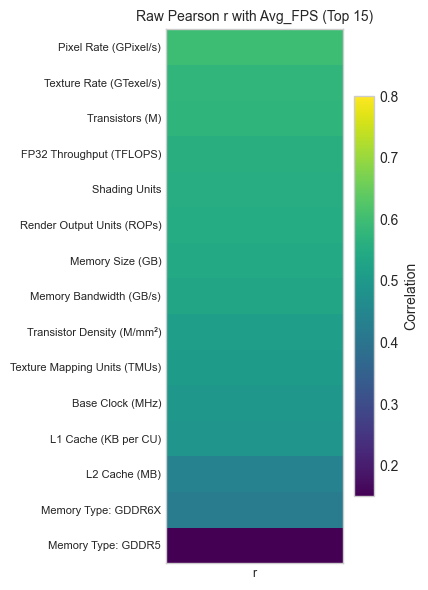

In [184]:
# --- Pearson-only meshed heatmap ---
K = 15
ordered = corr_sorted.head(K).copy()
ordered["feature_pretty"] = ordered["feature"].map(prettify_label)

fig, ax = plt.subplots(figsize=(4.2, 6))

# Make a column vector for pcolormesh
Z = np.atleast_2d(ordered["pearson_r"].values).T
ny, nx = Z.shape
x = np.arange(nx + 1)
y = np.arange(ny + 1)

# Sequential colormap for positive correlations
im = ax.pcolormesh(
    x, y, Z,
    cmap="viridis",
    vmin=0.15, vmax=0.8,
    edgecolors="none"   # ← removes white lines entirely
)


# Axis formatting
ax.set_yticks(np.arange(ny) + 0.5)
ax.set_yticklabels(ordered["feature_pretty"], fontsize=8)
ax.invert_yaxis()
ax.set_xticks([0.5])
ax.set_xticklabels(["r"], fontsize=9)

ax.set_title(f"Raw Pearson r with {TARGET} (Top {K})", fontsize=10, pad=6)
fig.colorbar(im, ax=ax, shrink=0.75, label="Correlation")

fig.tight_layout()
plt.show()


##### VIEW HARDWARE SPECS IN ISOLATION (LINEAR REGRESSION)

In [185]:
# --- Imports ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# =====================================================================
# Data & feature lists (assumes these already exist in your notebook):
#   - gpu_joined (DataFrame)
#   - numeric_features (list of numeric hardware columns, EXCLUDING "Avg_FPS")
#   - hardware_categorical_features = ["architecture", "memory_type"]
#   - all_hw_features = numeric_features + hardware_categorical_features
# =====================================================================

TARGET = "Avg_FPS"

X_hw = gpu_joined[all_hw_features]
y = gpu_joined[TARGET]

# Train/test split
X_train_hw, X_test_hw, y_train_hw, y_test_hw = train_test_split(
    X_hw, y, test_size=0.2, random_state=42
)

# Preprocessor: scale numeric, one-hot encode categoricals
preprocessor_hw = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), hardware_categorical_features),
    ],
    remainder="drop"
)

# Pipeline: preprocessing + linear regression
lr_hw = Pipeline(steps=[
    ("preprocessor", preprocessor_hw),
    ("regressor", LinearRegression())
])

# Fit
lr_hw.fit(X_train_hw, y_train_hw)
y_pred_hw_lr = lr_hw.predict(X_test_hw)

# R^2
r2_hw = r2_score(y_test_hw, y_pred_hw_lr)
print(f"Hardware-only Linear Regression R²: {r2_hw:.4f}")



Hardware-only Linear Regression R²: 0.4079


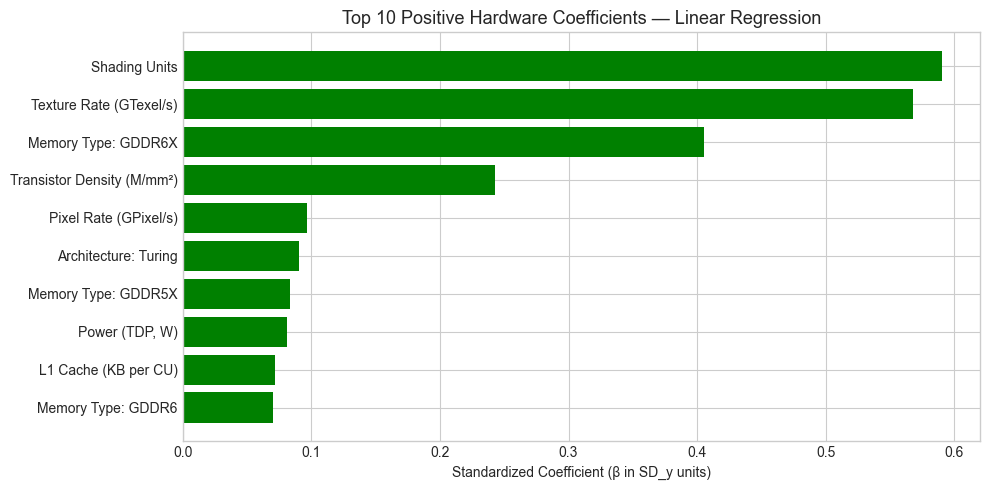

In [186]:
# ---------------------------------------------------------------------
# Extract aligned feature names & coefficients (in the MODEL'S space)
# - Numeric inputs are standardized (z-scores)
# - Categorical inputs are 0/1 dummies
# ---------------------------------------------------------------------
feat_names = lr_hw.named_steps["preprocessor"].get_feature_names_out()
coefs = lr_hw.named_steps["regressor"].coef_.astype(float)

# ---------------------------------------------------------------------
# Compute STANDARDIZED coefficients in units of SD_y (comparable):
# - For standardized numeric X, coefficient is in y-units per 1 SD_x.
#   To express per 1 SD_y, divide by sigma_y.
# - For 0/1 dummies, coefficient is y-units for switching 0→1; divide
#   by sigma_y to get SD_y units too.
# ---------------------------------------------------------------------
sigma_y = np.std(y_train_hw.astype(float), ddof=0)  # population SD for stability
coef_std = coefs / sigma_y

coef_df = (
    pd.DataFrame({
        "feature": feat_names,
        "coef": coefs,              # raw model-space (y units)
        "coef_std": coef_std,       # standardized to SD_y units (comparable)
        "abs_coef_std": np.abs(coef_std)
    })
    .sort_values("abs_coef_std", ascending=False)
    .reset_index(drop=True)
)

coef_df["feature_clean"] = (
    coef_df["feature"]
    .str.replace("^num__", "", regex=True)
    .str.replace("^cat__", "", regex=True)
)

# Use cleaned names in sorted subsets
top_k = 10
top_pos = coef_df.sort_values("coef_std", ascending=False).head(top_k).copy()
top_neg = coef_df.sort_values("coef_std", ascending=True).head(top_k).copy()

top_pos["feature_clean"] = (
    top_pos["feature"]
    .str.replace("^num__", "", regex=True)
    .str.replace("^cat__", "", regex=True)
)
top_neg["feature_clean"] = (
    top_neg["feature"]
    .str.replace("^num__", "", regex=True)
    .str.replace("^cat__", "", regex=True)
)


# ------------------------------
# Visualization: standardized β
# ------------------------------

coef_df["feature_clean"] = (
    coef_df["feature"]
    .str.replace(r"^(num__|cat__)", "", regex=True)
    .apply(prettify_label)
)

top_pos = coef_df.nlargest(10, "coef_std").copy()
top_neg = coef_df.nsmallest(10, "coef_std").copy()

plt.figure(figsize=(10, 5))
plt.barh(top_pos["feature_clean"], top_pos["coef_std"], color="green")
plt.title("Top 10 Positive Hardware Coefficients — Linear Regression", fontsize=13)
plt.xlabel("Standardized Coefficient (β in SD_y units)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

##### ANALYIZE GAME DRIVEN FPS IN ISOLATION (LINEAR REGRESSION)

In [187]:
def analyze_categorical_feature(df, feature, target="Avg_FPS", top_n=25):
    """
    Train regression on a categorical feature (or list of features) 
    and visualize coefficients.
    
    Parameters:
    -----------
    df : DataFrame
        Input dataset.
    feature : str or list
        Column name(s) to analyze.
    target : str
        Target variable (default = "Avg_FPS").
    top_n : int
        Number of top positive/negative coefficients to show.
    """
    # Ensure feature is list
    if isinstance(feature, str):
        feature = [feature]
    
    X = df[feature]
    y = df[target]

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2
    )

    # Preprocessor
    preprocessor = ColumnTransformer(
        transformers=[("cat", OneHotEncoder(handle_unknown="ignore"), feature)]
    )

    # Pipeline
    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("regressor", LinearRegression())
    ])

    # Fit model
    pipeline.fit(X_train, y_train)
    r2 = r2_score(y_test, pipeline.predict(X_test))

    # Extract feature names
    ohe = pipeline.named_steps["preprocessor"].named_transformers_["cat"]
    feature_names = ohe.get_feature_names_out(feature)
    feature_names = [name.split("_", 1)[1] for name in feature_names] 
    if len(feature) == 1:
        feature_names = [name.split("_", 1)[1] for name in feature_names]

    # Coefficients
    coeffs = pd.DataFrame({
        "Feature": feature_names,
        "Coefficient": pipeline.named_steps["regressor"].coef_
    }).sort_values(by="Coefficient", ascending=False)

    # Plot positive
    top_pos = coeffs.head(top_n)
    plt.figure(figsize=(10,6))
    plt.barh(top_pos["Feature"], top_pos["Coefficient"], color="green")
    plt.title(f"Top {top_n} Positive Coefficients for {feature}")
    plt.gca().invert_yaxis()
    plt.show()

    # Plot negative
    top_neg = coeffs.tail(top_n)
    plt.figure(figsize=(10,6))
    plt.barh(top_neg["Feature"], top_neg["Coefficient"], color="red")
    plt.title(f"Top {top_n} Negative Coefficients for {feature}")
    plt.gca().invert_yaxis()
    plt.show()

    return r2, coeffs

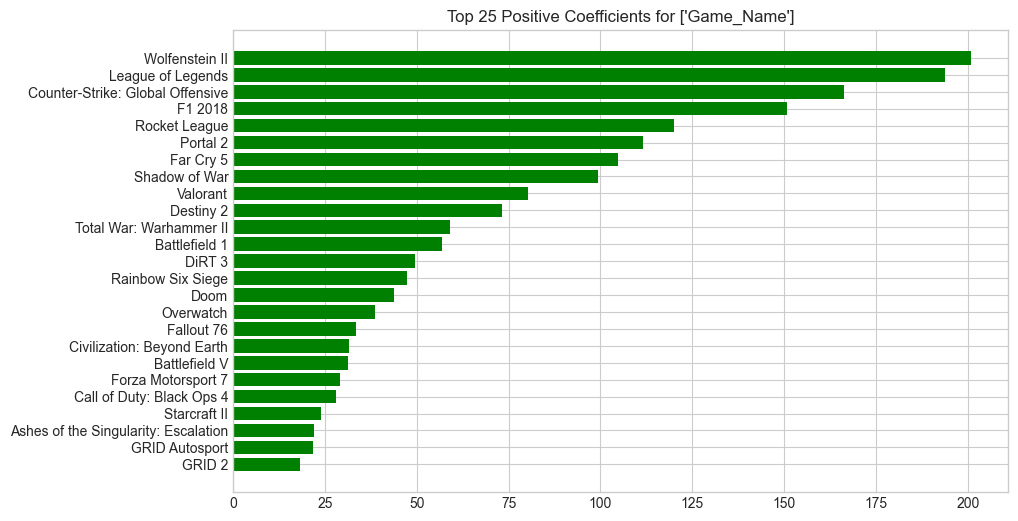

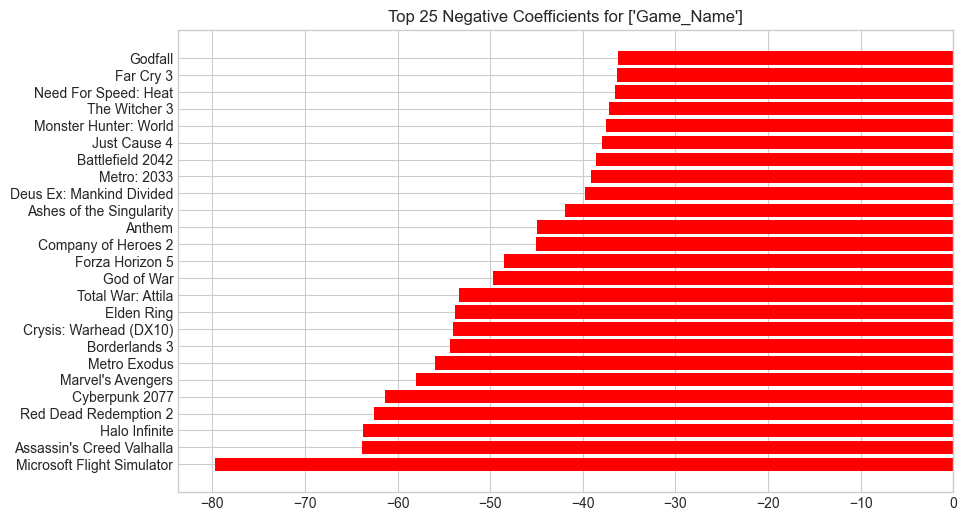

Game-only Linear Regression R²: 0.1758
                              Feature  Coefficient
102                    Wolfenstein II   200.932232
64                  League of Legends   193.904963
21   Counter-Strike: Global Offensive   166.334198
38                            F1 2018   150.730929
84                      Rocket League   120.075825
..                                ...          ...
25                     Cyberpunk 2077   -61.342897
81              Red Dead Redemption 2   -62.601187
59                      Halo Infinite   -63.762475
6           Assassin's Creed Valhalla   -63.875167
69         Microsoft Flight Simulator   -79.714691

[104 rows x 2 columns]


In [188]:
# Game-only
r2_game_lr, coeffs_game_lr = analyze_categorical_feature(gpu_joined, "Game_Name")
print(f"Game-only Linear Regression R²: {r2_game_lr:.4f}")
print(coeffs_game_lr)

##### GENERIC LINEAR REGRESSION MODEL (ALL FEATURES)

In [189]:
numeric_features_final = gpu_joined.select_dtypes(include=["float64"]).drop(columns=["Avg_FPS"]).columns.tolist()
categorical_features = ["Resolution", "Setting", "memory_type", "architecture"]

X = gpu_joined[numeric_features_final + categorical_features]
y = gpu_joined["Avg_FPS"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features_final),
        ("cat", OneHotEncoder(handle_unknown="ignore"), hardware_categorical_features + software_features)
    ]
)

# Pipeline
pipeline_baseline = Pipeline(steps=[("preprocessor", preprocessor),
                           ("regressor", LinearRegression())])

pipeline_baseline.fit(X_train, y_train)
y_pred = pipeline_baseline.predict(X_test)


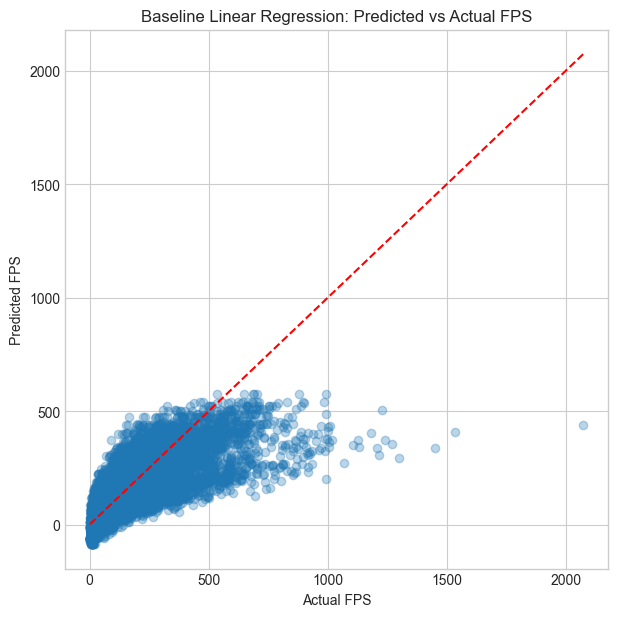

0.6323943759437994

In [190]:
# Evaluate
r2_baseline = r2_score(y_test, y_pred)

# Scatter plot predicted vs actual
plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual FPS")
plt.ylabel("Predicted FPS")
plt.title("Baseline Linear Regression: Predicted vs Actual FPS")
plt.show()

r2_baseline

In [191]:

print("Baseline Linear Regression R²:", r2_score(y_test, y_pred))

Baseline Linear Regression R²: 0.6323943759437994


### BASELINE LINEAR REGRESSION PREDICTING

In [192]:
def predict_fps_batch(pipeline, specs_list: list):
    """
    Predict FPS for a batch of GPU/game/resolution/setting configurations.

    Parameters:
    -----------
    pipeline : trained sklearn pipeline
        The trained baseline model pipeline.
    specs_list : list of dicts
        Each dict contains the required feature values for one configuration.

    Returns:
    --------
    DataFrame : input specs with an added 'Predicted_FPS' column
    """
    df = pd.DataFrame(specs_list)
    df["Predicted_FPS"] = pipeline.predict(df)
    return df

### XG BOOST MODEL

##### VIEW HARDWARE SPECS IN ISOLATION (XGBOOST)

In [193]:
#BASE XGBOOST MODEL FOR HARDWARE ONLY

xg_hw = Pipeline(steps=[
    ('preprocessor', preprocessor_hw),
    ('regressor', XGBRegressor())
])

xg_hw.fit(X_train_hw, y_train_hw)
y_pred_hw_xg = xg_hw.predict(X_test_hw)

r2_hw_xg = r2_score(y_test_hw, y_pred_hw_xg)
print(f"Hardware-only XGBoost R²: {r2_hw_xg:.4f}")

Hardware-only XGBoost R²: 0.4200


In [194]:
pre = xg_hw.named_steps["preprocessor"]
names_xg = pre.get_feature_names_out()  # includes 'num__', 'cat__' prefixes

# 2) Strip ColumnTransformer prefixes and prettify
import re
names_base = [re.sub(r"^(num|cat|passthrough|remainder)__", "", n) for n in names_xg]
names_pretty = [prettify_label(n) for n in names_base]

# 3) Build DataFrame aligned to model importances
xg_model = xg_hw.named_steps["regressor"]
fi = xg_model.feature_importances_.astype(float)

coeffs_hw_xg = (
    pd.DataFrame({
        "Feature_raw": names_xg,
        "Feature": names_base,
        "Feature_pretty": names_pretty,
        "Importance": fi
    })
    .sort_values("Importance", ascending=False)
    .reset_index(drop=True)
)

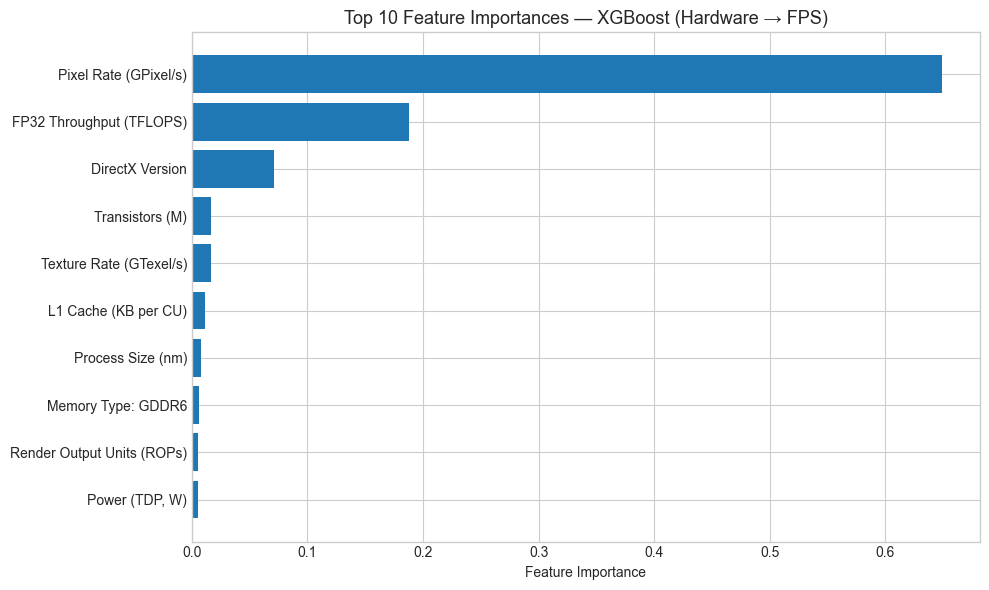

In [195]:
top_k = 10
top_xg = coeffs_hw_xg.head(top_k).copy()

plt.figure(figsize=(10, 6))
plt.barh(top_xg["Feature_pretty"], top_xg["Importance"])
plt.title(f"Top {top_k} Feature Importances — XGBoost (Hardware → FPS)", fontsize=13)
plt.xlabel("Feature Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

##### ANALYIZE GAME DRIVEN FPS IN ISOLATION (XG BOOST)

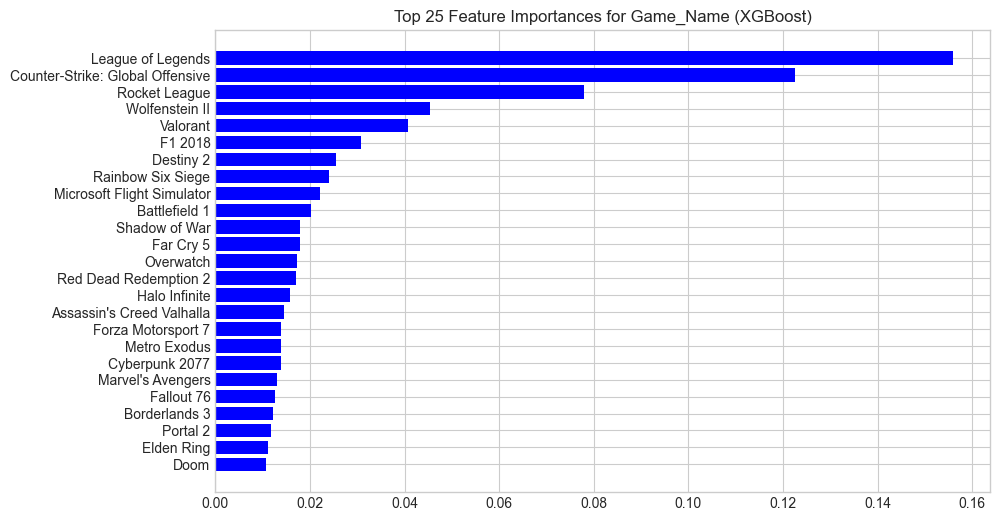

Game-only XGBoost R²: 0.1777


In [196]:
# Feature
feature = ["Game_Name"]
X = gpu_joined[feature]
y = gpu_joined["Avg_FPS"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2
)

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[("cat", OneHotEncoder(handle_unknown="ignore"), feature)]
)

# Pipeline with XGBoost
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", XGBRegressor(
        n_estimators=300, learning_rate=0.05, max_depth=6,
        subsample=0.8, colsample_bytree=0.8, n_jobs=-1
    ))
])

# Fit model
pipeline.fit(X_train, y_train)
r2 = r2_score(y_test, pipeline.predict(X_test))


# Get feature names
ohe = pipeline.named_steps["preprocessor"].named_transformers_["cat"]
feature_names = ohe.get_feature_names_out(feature)
feature_names = [name.split("_", 1)[1] for name in feature_names] 
if len(feature) == 1:
    feature_names = [name.split("_", 1)[1] for name in feature_names]

# Get importances
importances = pipeline.named_steps["regressor"].feature_importances_

coeffs = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Plot top 25
top_n = 25
top_pos = coeffs.head(top_n)
plt.figure(figsize=(10,6))
plt.barh(top_pos["Feature"], top_pos["Importance"], color="blue")
plt.title(f"Top {top_n} Feature Importances for Game_Name (XGBoost)")
plt.gca().invert_yaxis()
plt.show()

coeffs.head(10)
print(f"Game-only XGBoost R²: {r2:.4f}")

##### XG BOOST MODEL (ALL FEATURES)

In [197]:
numeric_features_final = gpu_joined.select_dtypes(include=["float64"]).drop(columns=["Avg_FPS"]).columns.tolist()
categorical_features = ["Resolution", "Setting", "memory_type", "architecture"]

X = gpu_joined[numeric_features_final + categorical_features]
y = gpu_joined["Avg_FPS"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features_final),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

# XGBoost pipeline
xgb_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", XGBRegressor())
])

# Fit and evaluate
xgb_pipeline.fit(X_train, y_train)
y_pred = xgb_pipeline.predict(X_test)

print("XGBoost R²:", r2_score(y_test, y_pred))

XGBoost R²: 0.7064044571570467


##### XG Boost Randomized CV

In [198]:
xgb_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", XGBRegressor(
        objective="reg:squarederror",
        tree_method="hist"
    ))
])

# -----------------------------
# 4. Hyperparameter distributions
# -----------------------------
param_dist = {
    # Core boosting parameters
    "regressor__n_estimators": randint(300, 1200),     # more trees → better performance, but slower
    "regressor__learning_rate": uniform(0.01, 0.3),    # extend to 0.3 (common sweet spot with lower trees)
    "regressor__max_depth": randint(2, 12),            # allow very shallow to deeper trees
    "regressor__min_child_weight": randint(1, 15),     # stricter leaf constraints → reduce overfitting

    # Subsampling parameters
    "regressor__subsample": uniform(0.5, 0.5),         # between 0.5–1.0 → prevent overfitting
    "regressor__colsample_bytree": uniform(0.5, 0.5),  # feature sampling 50–100%

    # Regularization parameters
    "regressor__reg_alpha": uniform(0, 5),             # widen range for L1
    "regressor__reg_lambda": uniform(0, 20),           # widen range for L2

    # Additional useful knobs
    "regressor__gamma": uniform(0, 5),                 # min loss reduction for splits → controls complexity
    "regressor__max_delta_step": randint(0, 5),        # helps with imbalanced data (small values usually fine)
    "regressor__scale_pos_weight": uniform(0.5, 2),    # useful if classes/targets are imbalanced
}


# -----------------------------
# 5. Randomized Search
# -----------------------------
random_search = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=param_dist,
    n_iter=10,        # start small
    scoring="r2",
    cv=5,             # fewer folds for testing
    n_jobs=1
)

# -----------------------------
# 6. Fit & Evaluate
# -----------------------------
random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best CV R²:", random_search.best_score_)

# Evaluate on test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Test R²:", r2_score(y_test, y_pred))

Best Parameters: {'regressor__colsample_bytree': np.float64(0.622188648458329), 'regressor__gamma': np.float64(3.3134992098552973), 'regressor__learning_rate': np.float64(0.26103076910562134), 'regressor__max_delta_step': 0, 'regressor__max_depth': 4, 'regressor__min_child_weight': 3, 'regressor__n_estimators': 357, 'regressor__reg_alpha': np.float64(1.7044762143574832), 'regressor__reg_lambda': np.float64(5.469617340310265), 'regressor__scale_pos_weight': np.float64(0.9440726805882513), 'regressor__subsample': np.float64(0.5040425675258442)}
Best CV R²: 0.6978458514432192
Test R²: 0.7072934296557518


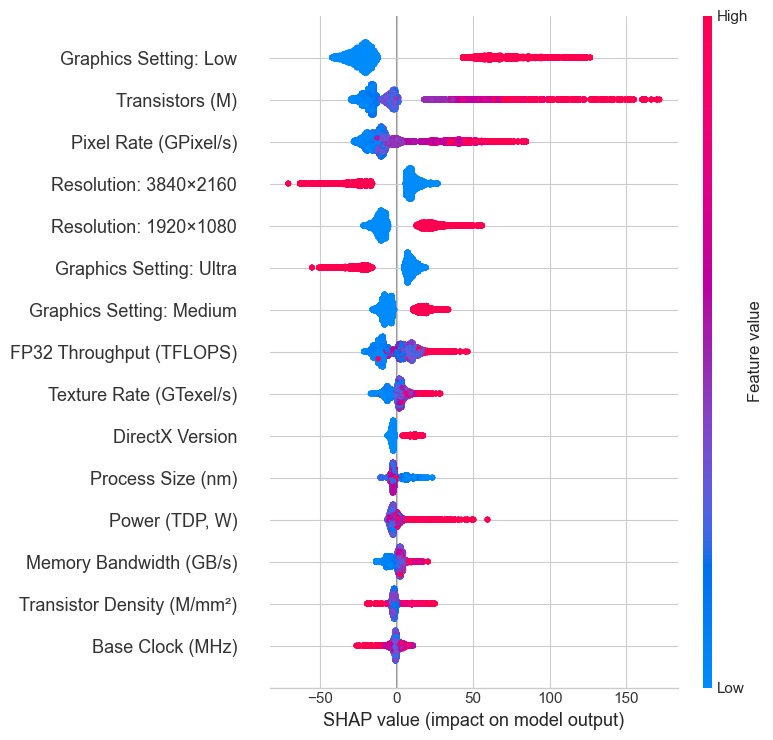

In [199]:
fitted_pipeline = random_search.best_estimator_

# --- 1) Get feature names in the exact order used by the model ---
pre = fitted_pipeline.named_steps["preprocessor"]
feature_names_raw = pre.get_feature_names_out()      # e.g., 'num__pixel_rate_GPixel/s', 'cat__Resolution_3840x2160'

# Strip ColumnTransformer prefixes, then prettify
feature_names_base = [re.sub(r"^(num|cat|passthrough|remainder)__", "", n) for n in feature_names_raw]
feature_names_pretty = [prettify_label(n) for n in feature_names_base]

# --- 2) Importances aligned with model columns ---
xgb_reg = fitted_pipeline.named_steps["regressor"]
importances = xgb_reg.feature_importances_.astype(float)

feat_imp = (
    pd.DataFrame({
        "Feature_raw": feature_names_raw,
        "Feature": feature_names_base,
        "Feature_pretty": feature_names_pretty,
        "Importance": importances
    })
    .sort_values("Importance", ascending=False)
    .reset_index(drop=True)
)

X_train_trans = pre.transform(X_train)
X_test_trans  = pre.transform(X_test)

explainer = shap.TreeExplainer(xgb_reg)
shap_values = explainer(X_test_trans)

# Use pretty labels at plot time (keeps model internals unchanged)
shap.summary_plot(
    shap_values,
    features=X_test_trans,
    feature_names=feature_names_pretty,
    max_display=15
)

In [200]:
np.shape(shap_values.values)

(31752, 40)

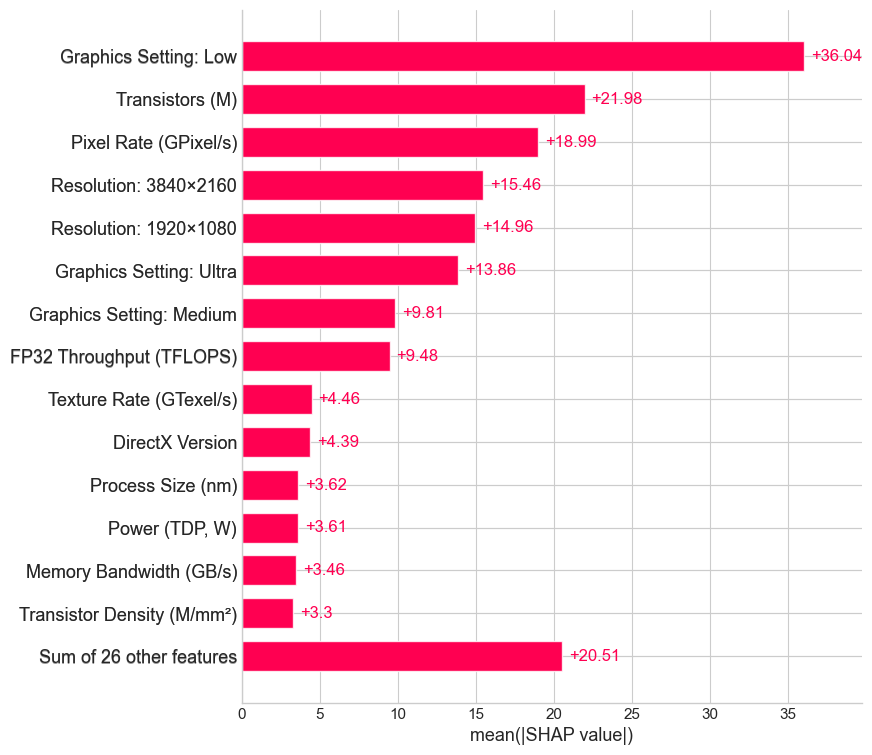

In [207]:
shap_values.feature_names = feature_names_pretty

# --- Plot the SHAP summary bar chart ---
shap.plots.bar(shap_values, max_display=15)

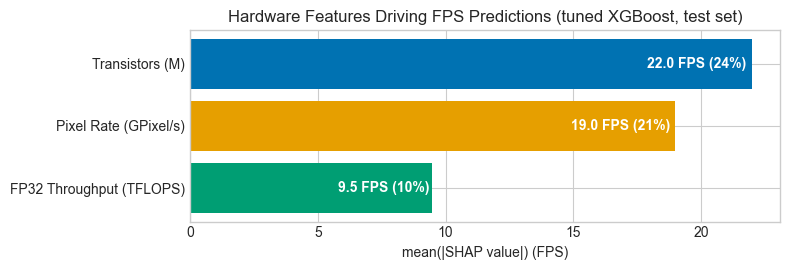

In [228]:
import re
import numpy as np
import matplotlib.pyplot as plt

# 1) Get feature names aligned with SHAP
pre = fitted_pipeline.named_steps["preprocessor"]
feature_names_raw = pre.get_feature_names_out()

# 2) Strip prefixes (num__/cat__/etc.)
names_base = [re.sub(r"^(num|cat|passthrough|remainder)__", "", n) for n in feature_names_raw]

# 3) Detect and remove software/contextual features
def is_software_feat(name: str) -> bool:
    base = name.split("_", 1)[0].lower()
    return base in {"setting", "resolution"}

keep_mask = np.array([not is_software_feat(n) for n in names_base])

# 4) Mean absolute SHAP values
vals = shap_values.values
mean_abs = np.nanmean(np.abs(vals), axis=0)
mean_abs_hw = mean_abs[keep_mask]

# 5) Clean names for labeling
names_pretty = [prettify_label(n) for n in names_base]
names_pretty_hw = np.array(names_pretty)[keep_mask]

# 6) Pick top-N hardware features
topN = 3
order = np.argsort(mean_abs_hw)[::-1][:topN]
top_vals = mean_abs_hw[order]
top_names = names_pretty_hw[order]

# 7) Compute relative share (vs hardware-only total)
share = 100 * top_vals / mean_abs_hw.sum()

# 8) Plot with your labeling style
fig, ax = plt.subplots(figsize=(8, 2.8))
colors = ["#0072B2", "#E69F00", "#009E73"]

bars = ax.barh(top_names, top_vals, color=colors)
ax.invert_yaxis()
ax.set_xlabel("mean(|SHAP value|) (FPS)")
ax.set_title("Hardware Features Driving FPS Predictions (tuned XGBoost, test set)")

# Your label format — same as your example
for i, (v, pct) in enumerate(zip(top_vals, share)):
    ax.text(v * 0.99, i, f"{v:.1f} FPS ({pct:.0f}%)",
            va='center', ha='right', color='white',
            fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()




In [255]:
# ---------------- SAFETY CHECKS & REBUILD ----------------
import numpy as np, pandas as pd, re

# 0) Use the same pipeline for everything
pipe = fitted_pipeline                         # <-- make sure this is the one you used for SHAP
pre  = pipe.named_steps["preprocessor"]
model = pipe.named_steps["regressor"]

# 1) Names must match SHAP width
feature_names_raw = pre.get_feature_names_out()
assert shap_values.values.shape[1] == len(feature_names_raw), \
    f"SHAP n_features {shap_values.values.shape[1]} != names {len(feature_names_raw)}"

# 2) Build SHAP df with index aligned to X_test (force alignment defensively)
shap_df = pd.DataFrame(
    shap_values.values,
    columns=[f"{c}_SHAP" for c in feature_names_raw],
    index=None
)
X_test_safe = X_test.reset_index(drop=True)
shap_df     = shap_df.reset_index(drop=True)

X_test_with_shap = pd.concat([X_test_safe, shap_df], axis=1, copy=False)
assert len(X_test_with_shap) == len(X_test_safe) == len(shap_df)

# 3) Hardware feature list (base numeric columns)
hardware_features = gpu_joined.select_dtypes(include=["float64"]).columns.tolist()
hardware_set = set(hardware_features)

# 4) Strip prefixes for base comparison + pretty labels
def strip_prefix(name: str) -> str:
    return re.sub(r"^(num|cat|passthrough|remainder)__", "", name)

def base_token(name: str) -> str:
    return strip_prefix(name).split("_", 1)[0]

feature_names_base = [strip_prefix(n) for n in feature_names_raw]

# 5) Rank features by global mean |SHAP|
vals = shap_values.values
mean_abs = np.nanmean(np.abs(vals), axis=0)

shap_importance = pd.DataFrame({
    "FeatureRaw": feature_names_raw,
    "FeatureBase": feature_names_base,
    "MeanAbsSHAP": mean_abs
})

# Pick top hardware features (same criterion as before)
top_hw_df = (shap_importance[shap_importance["FeatureBase"].isin(hardware_set)]
             .sort_values("MeanAbsSHAP", ascending=False)
             .head(10)
             .copy())

# Optional: verify we didn’t accidentally switch to different features than last run
print("Top HW features (raw):", top_hw_df["FeatureRaw"].tolist())

# 6) Build column names for SHAP columns (transformed names)
top_hw_cols = [f"{c}_SHAP" for c in top_hw_df["FeatureRaw"]]

# 7) Grouping — compute both mean(|SHAP|) and mean(SHAP)
# Normalize common categorical variants for robust grouping
X_test_with_shap["Resolution"] = X_test_with_shap["Resolution"].astype(str)
X_test_with_shap["Setting"]    = X_test_with_shap["Setting"].astype(str).str.lower()

res_order = ["1920x1080", "2560x1440", "3440x1440", "3840x2160"]
set_order = ["low", "medium", "high", "ultra"]

grouped_res_abs = (X_test_with_shap.groupby("Resolution")[top_hw_cols]
                   .apply(lambda df: df.abs().mean()))
grouped_res_signed = X_test_with_shap.groupby("Resolution")[top_hw_cols].mean()

grouped_set_abs = (X_test_with_shap.groupby("Setting")[top_hw_cols]
                   .apply(lambda df: df.abs().mean()))
grouped_set_signed = X_test_with_shap.groupby("Setting")[top_hw_cols].mean()

# Reindex to consistent order (drop rows with all-NaN only)
grouped_res_abs    = grouped_res_abs.reindex(res_order).dropna(how="all")
grouped_res_signed = grouped_res_signed.reindex(res_order).dropna(how="all")
grouped_set_abs    = grouped_set_abs.reindex(set_order).dropna(how="all")
grouped_set_signed = grouped_set_signed.reindex(set_order).dropna(how="all")

# Column pretty names (for plotting/printing)
top_hw_df["FeaturePretty"] = top_hw_df["FeatureBase"].apply(prettify_label)
pretty_cols = top_hw_df["FeaturePretty"].tolist()
rename_map = dict(zip(top_hw_cols, pretty_cols))

grouped_res_abs    = grouped_res_abs.rename(columns=rename_map)
grouped_res_signed = grouped_res_signed.rename(columns=rename_map)
grouped_set_abs    = grouped_set_abs.rename(columns=rename_map)
grouped_set_signed = grouped_set_signed.rename(columns=rename_map)

# Quick NA diagnostics
for name, g in [("res_abs", grouped_res_abs), ("res_signed", grouped_res_signed),
                ("set_abs", grouped_set_abs), ("set_signed", grouped_set_signed)]:
    missing = sorted(set(pretty_cols) - set(g.columns))
    if missing:
        print(f"[warn] {name} missing columns (likely no data in some group):", missing)


# --- H) Display all results ---
display("🔹 Mean Absolute |SHAP| by Resolution (Hardware Only):", grouped_res_abs)
display("🔹 Mean Signed SHAP by Resolution (Hardware Only):", grouped_res_signed)

display("🔹 Mean Absolute |SHAP| by Setting (Hardware Only):", grouped_set_abs)
display("🔹 Mean Signed SHAP by Setting (Hardware Only):", grouped_set_signed)


Top HW features (raw): ['num__transistors_million', 'num__pixel_rate_GPixel/s', 'num__fp32_TFLOPS', 'num__texture_rate_GTexel/s', 'num__directx', 'num__process_size_nm', 'num__tdp_W', 'num__bandwidth_GBs', 'num__density_M__per__mm^2', 'num__base_clock_MHz']


'🔹 Mean Absolute |SHAP| by Resolution (Hardware Only):'

,Transistors (M),Pixel Rate (GPixel/s),FP32 Throughput (TFLOPS),Texture Rate (GTexel/s),DirectX Version,Process Size (nm),"Power (TDP, W)",Memory Bandwidth (GB/s),Transistor Density (M/mm²),Base Clock (MHz)
Resolution,,,,,,,,,,
1920x1080,23.134256,20.924759,10.072312,5.089427,4.563071,4.040065,3.933227,4.038618,3.547045,2.613215
2560x1440,21.810047,18.837303,9.214365,4.547326,4.641824,3.893236,3.541762,3.811395,2.982381,2.134800
3440x1440,25.959814,21.516712,9.744920,4.805554,5.179250,3.834311,3.613584,3.511260,4.410663,2.192830
3840x2160,18.937265,15.736775,8.970575,3.473314,3.532634,2.735443,3.323213,2.404491,2.823969,1.994842


'🔹 Mean Signed SHAP by Resolution (Hardware Only):'

,Transistors (M),Pixel Rate (GPixel/s),FP32 Throughput (TFLOPS),Texture Rate (GTexel/s),DirectX Version,Process Size (nm),"Power (TDP, W)",Memory Bandwidth (GB/s),Transistor Density (M/mm²),Base Clock (MHz)
Resolution,,,,,,,,,,
1920x1080,-1.996035,-1.820026,-0.996301,0.223052,-0.266324,0.121506,-0.109408,0.279217,-0.639802,-0.387892
2560x1440,-1.918257,-0.988751,-0.680845,0.265388,-0.132870,0.144687,-0.038096,0.328266,-0.036881,-0.298061
3440x1440,7.232458,6.920168,2.552205,1.143263,1.115210,1.323030,1.336115,1.424340,1.458176,-0.252124
3840x2160,-1.112220,-0.244339,-0.096045,0.199933,0.094615,0.266668,0.007286,0.343556,0.091805,-0.337959


'🔹 Mean Absolute |SHAP| by Setting (Hardware Only):'

,Transistors (M),Pixel Rate (GPixel/s),FP32 Throughput (TFLOPS),Texture Rate (GTexel/s),DirectX Version,Process Size (nm),"Power (TDP, W)",Memory Bandwidth (GB/s),Transistor Density (M/mm²),Base Clock (MHz)
Setting,,,,,,,,,,
low,26.864250,23.503691,11.584669,5.509910,4.712958,5.813734,4.310359,4.049430,3.602208,2.440844
medium,20.035336,19.497871,9.638076,4.442246,4.787199,2.952673,3.832358,4.052004,3.637408,2.453844
high,20.407545,18.237028,8.688502,3.950104,4.846768,3.076730,3.297655,3.441813,2.490153,1.869393
ultra,20.478609,14.543707,7.934926,3.896014,3.185409,2.577276,2.980771,2.282290,3.442411,2.231258


'🔹 Mean Signed SHAP by Setting (Hardware Only):'

,Transistors (M),Pixel Rate (GPixel/s),FP32 Throughput (TFLOPS),Texture Rate (GTexel/s),DirectX Version,Process Size (nm),"Power (TDP, W)",Memory Bandwidth (GB/s),Transistor Density (M/mm²),Base Clock (MHz)
Setting,,,,,,,,,,
low,-0.319618,0.296785,0.131851,0.134686,0.154074,0.454292,0.254716,0.583993,0.039117,-0.447211
medium,-1.374350,-0.027368,-0.321823,0.536800,0.067704,0.231433,0.086385,0.381466,-0.076914,-0.270070
high,-0.208069,0.016649,-0.422245,0.514248,0.070196,0.284828,-0.036266,0.431548,0.082554,-0.423760
ultra,-0.293783,-0.404299,-0.214280,0.206891,-0.105046,0.313842,0.208514,0.433137,-0.021899,-0.176347


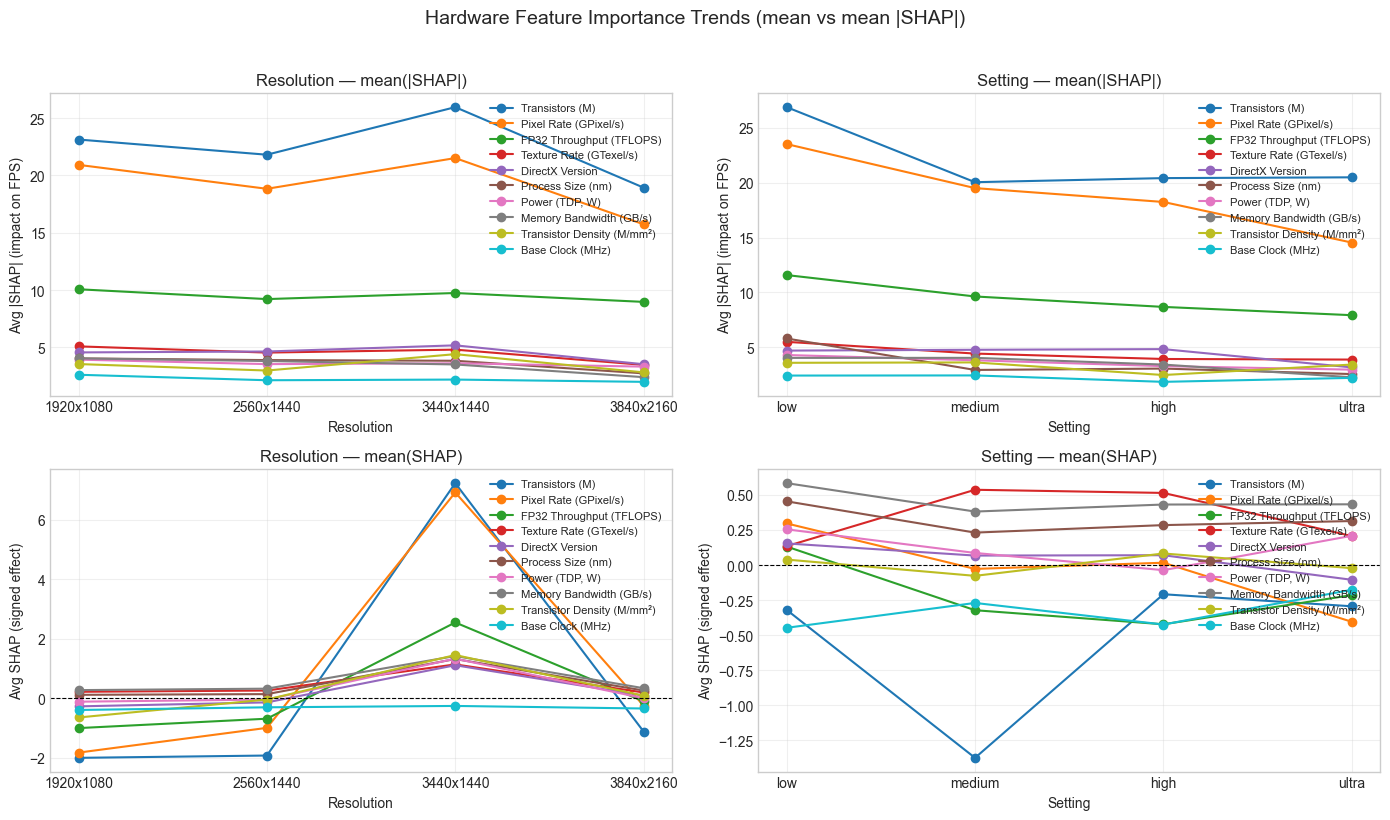

In [256]:
import numpy as np
import matplotlib.pyplot as plt

# Choose top-N hardware features to plot
top_n = 10
overall_rank = (
    grouped_res_abs.mean(axis=0)
    .add(grouped_set_abs.mean(axis=0), fill_value=0)
    .sort_values(ascending=False)
)
cols = overall_rank.index[:top_n].tolist()

# Define x-axis orders
resolution_order = ["1920x1080", "2560x1440", "3440x1440", "3840x2160"]
setting_order    = ["low", "medium", "high", "ultra"]

# Align group DataFrames and select top features
res_abs_plot    = grouped_res_abs.reindex(resolution_order).dropna(how="all")[cols]
set_abs_plot    = grouped_set_abs.reindex(setting_order).dropna(how="all")[cols]
res_signed_plot = grouped_res_signed.reindex(resolution_order).dropna(how="all")[cols]
set_signed_plot = grouped_set_signed.reindex(setting_order).dropna(how="all")[cols]

# --- Create the 2×2 figure layout ---
fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharey=False)

# === TOP ROW: mean absolute SHAP ===
# (1) Resolution |SHAP|
ax = axes[0, 0]
for c in cols:
    ax.plot(res_abs_plot.index, res_abs_plot[c].values, marker="o", label=c)
ax.set_title("Resolution — mean(|SHAP|)")
ax.set_xlabel("Resolution")
ax.set_ylabel("Avg |SHAP| (impact on FPS)")
ax.grid(True, alpha=0.3)
ax.legend(loc="upper right", fontsize=8, frameon=False)

# (2) Setting |SHAP|
ax = axes[0, 1]
for c in cols:
    ax.plot(set_abs_plot.index, set_abs_plot[c].values, marker="o", label=c)
ax.set_title("Setting — mean(|SHAP|)")
ax.set_xlabel("Setting")
ax.set_ylabel("Avg |SHAP| (impact on FPS)")
ax.grid(True, alpha=0.3)
ax.legend(loc="upper right", fontsize=8, frameon=False)

# === BOTTOM ROW: mean signed SHAP ===
# (3) Resolution mean(SHAP)
ax = axes[1, 0]
for c in cols:
    ax.plot(res_signed_plot.index, res_signed_plot[c].values, marker="o", label=c)
ax.set_title("Resolution — mean(SHAP)")
ax.set_xlabel("Resolution")
ax.set_ylabel("Avg SHAP (signed effect)")
ax.axhline(0, color="black", lw=0.8, linestyle="--")
ax.grid(True, alpha=0.3)
ax.legend(loc="upper right", fontsize=8, frameon=False)

# (4) Setting mean(SHAP)
ax = axes[1, 1]
for c in cols:
    ax.plot(set_signed_plot.index, set_signed_plot[c].values, marker="o", label=c)
ax.set_title("Setting — mean(SHAP)")
ax.set_xlabel("Setting")
ax.set_ylabel("Avg SHAP (signed effect)")
ax.axhline(0, color="black", lw=0.8, linestyle="--")
ax.grid(True, alpha=0.3)
ax.legend(loc="upper right", fontsize=8, frameon=False)

fig.suptitle("Hardware Feature Importance Trends (mean vs mean |SHAP|)", fontsize=14, y=1.02)
fig.tight_layout()
plt.show()


In [ ]:
feature_order = [
    "GPU_Name",
    "architecture",
    "process_size_nm",
    "transistors_million",
    "density_M__per__mm^2",
    "die_size_mm²",
    "base_clock_MHz",
    "memory_size_GB",
    "memory_type",
    "memory_bus_bit",
    "bandwidth_GBs",
    "shading_units",
    "tmus",
    "rops",
    "l1_cache_KB_per_CU",
    "l2_cache_MB",
    "directx",
    "tdp_W",
    "memory_clock_MHz",
    "fp32_TFLOPS",
    "fp64_TFLOPS",
    "pixel_rate_GPixel/s",
    "texture_rate_GTexel/s",
    "Game_Name",
    "Avg_FPS",
    "Setting",
    "Resolution"
]

In [ ]:
def parse_spec_string(spec_string: str, feature_order: list) -> dict:
    """
    Convert a CSV-like GPU spec string into a dict for prediction.

    Parameters
    ----------
    spec_string : str
        Comma-separated string of feature values.
    feature_order : list
        List of feature names in the same order as the string.

    Returns
    -------
    dict : Parsed dictionary (ignores Game_Name and Avg_FPS if present).
    """
    values = spec_string.split(",")
    spec_dict = dict(zip(feature_order, values))

    # Drop fields you don't want as predictors
    spec_dict.pop("GPU_Name", None)
    spec_dict.pop("Game_Name", None)
    spec_dict.pop("Avg_FPS", None)

    # Convert numeric fields from str → float
    for key in spec_dict:
        try:
            spec_dict[key] = float(spec_dict[key])
        except ValueError:
            pass  # keep as string if not convertible

    return spec_dict

In [ ]:
spec_string = "AMD Radeon 530 Mobile,Other,28.0,1550.0,12.4,125.0,730.0,2.0,Other,64.0,14.4,384.0,24.0,8.0,16.0,0.125,12.0,50.0,900.0,0.78,0.05,8.168,24.5,Assassin's Creed Origins,7.0,ultra,2560x1440"

parsed_dict = parse_spec_string(spec_string, feature_order)

batch_specs = [parsed_dict]
batch_predictions = predict_fps_batch(pipeline_baseline, batch_specs)

display(batch_predictions)

,architecture,process_size_nm,transistors_million,density_M__per__mm^2,die_size_mm²,base_clock_MHz,memory_size_GB,memory_type,memory_bus_bit,bandwidth_GBs,...,directx,tdp_W,memory_clock_MHz,fp32_TFLOPS,fp64_TFLOPS,pixel_rate_GPixel/s,texture_rate_GTexel/s,Setting,Resolution,Predicted_FPS
0,Other,28.0,1550.0,12.4,125.0,730.0,2.0,Other,64.0,14.4,...,12.0,50.0,900.0,0.78,0.05,8.168,24.5,ultra,2560x1440,-21.595455


In [ ]:
spec_string = "AMD Radeon 530 Mobile,Other,28.0,1550.0,12.4,125.0,730.0,2.0,Other,64.0,14.4,384.0,24.0,8.0,16.0,0.125,12.0,50.0,900.0,0.78,0.05,8.168,24.5,Assassin's Creed Origins,7.0,ultra,2560x1440"

parsed_dict = parse_spec_string(spec_string, feature_order)

batch_specs = [parsed_dict]
batch_predictions = predict_fps_batch(fitted_pipeline, batch_specs)

display(batch_predictions)

,architecture,process_size_nm,transistors_million,density_M__per__mm^2,die_size_mm²,base_clock_MHz,memory_size_GB,memory_type,memory_bus_bit,bandwidth_GBs,...,directx,tdp_W,memory_clock_MHz,fp32_TFLOPS,fp64_TFLOPS,pixel_rate_GPixel/s,texture_rate_GTexel/s,Setting,Resolution,Predicted_FPS
0,Other,28.0,1550.0,12.4,125.0,730.0,2.0,Other,64.0,14.4,...,12.0,50.0,900.0,0.78,0.05,8.168,24.5,ultra,2560x1440,1.829743
